# Libraries

In [5]:
import sys
import os

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('weld_quality_prediction'), '..')))

from data_preprocessing.functions import *
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import numpy as np

from itertools import product
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#import xgboost as xgb


# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Extraction

In [6]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)

column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

# Model Training

## Class for Model Selection

In [7]:
from itertools import product
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class ModelSelector:
    
    def __init__(self, *, model_class, labels_selected : list, data, param_grid_data, param_grid_model, kfold_splits):
        self.model_class = model_class
        self.labels_selected = labels_selected
        self.data = data
        self.param_grid_data = param_grid_data
        self.param_grid_model = param_grid_model
        self.kfold_splits = kfold_splits
        
    def extract_x_y(self):
        #Replace 'N' value with Nan
        data = replace_data(self.data)

        #Selection fof the data for supervised learning
        data_with_label = data.copy()
        data_with_label = data_with_label[data_with_label[self.labels_selected].notna().all(axis=1)]

        #Separation of features and labels
        self.X, self.y = choose_labels(data_with_label, labels_chosen=self.labels_selected)
            
    def split(self, test_size=0.2, random_state=42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, shuffle=True, random_state=random_state)

    def cross_validation(self):
        # KFold cross-validation
        kfolds = KFold(n_splits=5)
        
        # Dictionnaire pour stocker les RMSE moyens pour chaque combinaison d'hyperparamètres
        results = {}

        # Générer toutes les combinaisons d'hyperparamètres
        param_grid_total = self.param_grid_data | self.param_grid_model
        keys, values = zip(*param_grid_total.items())
        combinations = list(product(*values))

        # Itérer sur chaque combinaison d'hyperparamètres
        for combo in combinations:
            params = dict(zip(keys, combo))
            
            rmse_list = []  # Pour stocker les RMSE de chaque fold

            for fold, (train_index, val_index) in enumerate(kfolds.split(self.X_train, self.y_train)):
                model = self.model_class(**{k:v for k,v in params.items() if k in self.param_grid_model})
                
                X_sub_train = self.X_train.iloc[train_index, :]
                X_sub_val = self.X_train.iloc[val_index, :]
                y_sub_train = self.y_train.iloc[train_index]
                y_sub_val = self.y_train.iloc[val_index]

                # Appliquer le pipeline avec les paramètres
                X_sub_train, X_sub_val, y_sub_train, y_sub_val = pipeline_training_set(
                    training_set=X_sub_train, training_labels=y_sub_train,
                    testing_set=X_sub_val, testing_labels=y_sub_val, 
                    labels_chosen=self.labels_selected,
                    categorical_strategy=params['CategoricalStrategies'], 
                    ordinal_strategy=params['OrdinalStrategies'], 
                    is_PCA=True, 
                    pca_percent_explained_variance=0.85,
                    scaler_strategy=params['ScalerStrategy'], 
                    pca_columns=params['PcaColumns'], 
                    less_than_strategy=params['LessThanStrategy']
                )
                
                # Entraînement et prédiction
                model.fit(X_sub_train, y_sub_train)
            
                y_sub_pred = model.predict(X_sub_val)
                mse = mean_squared_error(y_sub_pred, y_sub_val)
                rmse = np.sqrt(mse)
                rmse_list.append(rmse)

            # Calculer la moyenne des RMSE pour cette combinaison
            mean_rmse = np.mean(rmse_list)
            results[tuple(combo)] = mean_rmse

        # Trouver les meilleurs hyperparamètres
        best_combo = min(results, key=results.get)
        self.best_rmse = results[best_combo]
        self.best_params = dict(zip(keys, best_combo))

        print("Best hyperparameters with cross-validation : {}".format(self.best_params))
        print("Best Mean RMSE on cross-validation : {:.3}".format(self.best_rmse))
    
    def score(self):
        # Appliquer le pipeline avec les paramètres
        X_train, X_test, y_train, y_test = pipeline_training_set(
                    training_set=self.X_train, training_labels=self.y_train,
                    testing_set=self.X_test, testing_labels=self.y_test, 
                    labels_chosen=self.labels_selected,
                    categorical_strategy=self.best_params['CategoricalStrategies'], 
                    ordinal_strategy=self.best_params['OrdinalStrategies'], 
                    is_PCA=True, 
                    pca_percent_explained_variance=0.85,
                    scaler_strategy=self.best_params['ScalerStrategy'], 
                    pca_columns=self.best_params['PcaColumns'], 
                    less_than_strategy=self.best_params['LessThanStrategy']
                )
        model = self.model_class(**{k:v for k,v in self.best_params.items() if k in self.param_grid_model})
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_pred, y_test)
        rmse = np.sqrt(mse)
        print("Final RMSE on test set : {:.3}".format(rmse))

## Simple Linear Regression

In [9]:
# Selection of the data hyper parameters on a simple model in order to store then for more complex models

model_class = LinearRegression
labels_selected = ["Yield_strength"]

param_grid_data = {
        'OrdinalStrategies': ["mean", "linear"],
        'CategoricalStrategies': ["most_frequent", "logistic"],
        'ScalerStrategy': ["standard", "normalizer"],
        'pca_percent_explained_variance' : [0.3, 0.4, 0.5, 0.6, 0.7],
        'PcaColumns': ['concentration', 'all_ordinals'],
        'LessThanStrategy': ['max', 'mean']
    }

param_grid_linear = {}

kfold_splits = 5

model = ModelSelector(model_class= model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_linear, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
model.score()

"""
Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'pca_percent_explained_variance': 0.3, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean'}
Best Mean RMSE on cross-validation : 78.1
Final RMSE on test set : 77.2
"""

KeyboardInterrupt: 

## XGboost

In [10]:
from sklearn.neighbors import KNeighborsRegressor

model_class = KNeighborsRegressor
labels_selected = ["Yield_strength"]

param_grid_data = {'OrdinalStrategies': ['mean'], 'CategoricalStrategies': ['most_frequent'], 'ScalerStrategy': ['standard'],
                   'pca_percent_explained_variance': [0.5, 0.6, 0.7, 0.8], 'PcaColumns': ['all_ordinals'], 'LessThanStrategy': ['mean']}

param_grid_KNN = {
    'n_neighbors': [1,3,5,7,9,11,13],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2, 3]
}

kfold_splits = 5

model = ModelSelector(model_class=model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_KNN, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
model.score()

Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'pca_percent_explained_variance': 0.6, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 50, 'p': 1}
Best Mean RMSE on cross-validation : 59.6
Final RMSE on test set : 56.9


Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'pca_percent_explained_variance': 0.6, 'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 50, 'p': 1}
Best Mean RMSE on cross-validation : 67.7
Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'pca_percent_explained_variance': 0.6, 'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 50, 'p': 1}
Best Mean RMSE on cross-validation : 59.4
Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'pca_percent_explained_variance': 0.6, 'n_neighbors': 5, 'weights': 'distance', 'leaf_size'

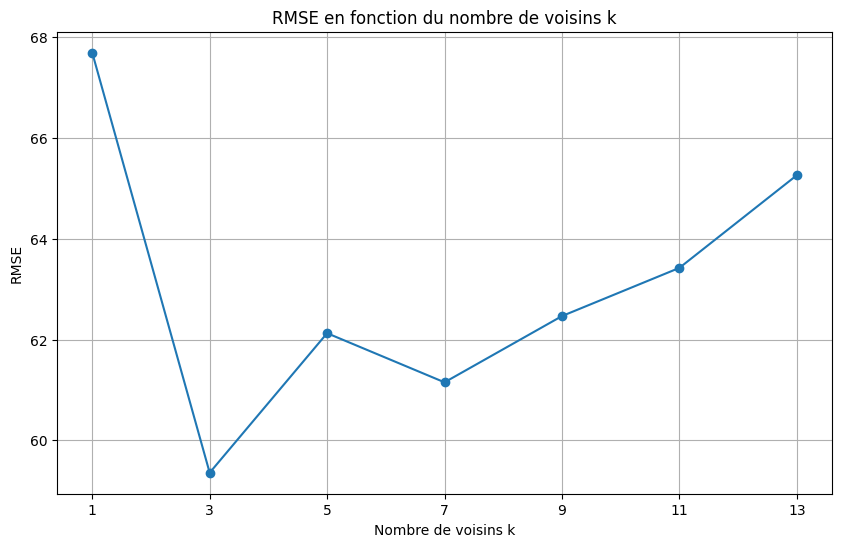

In [11]:
fixed_params = {
    'OrdinalStrategies': 'mean',
    'CategoricalStrategies': 'most_frequent',
    'ScalerStrategy': 'standard',
    'pca_percent_explained_variance': 0.6,
    'PcaColumns': 'all_ordinals',
    'LessThanStrategy': 'mean',
    'weights': 'distance',
    'leaf_size': 50,
    'p': 1
}

# Liste des valeurs de n_neighbors à tester
n_neighbors_list = [1, 3, 5, 7, 9, 11, 13]
rmse_list = []

for k in n_neighbors_list:
    # Mise à jour du paramètre n_neighbors
    params = fixed_params.copy()
    params['n_neighbors'] = k

    # Création du grid des hyperparamètres
    param_grid_data = {
        'OrdinalStrategies': [params['OrdinalStrategies']],
        'CategoricalStrategies': [params['CategoricalStrategies']],
        'ScalerStrategy': [params['ScalerStrategy']],
        'PcaColumns': [params['PcaColumns']],
        'LessThanStrategy': [params['LessThanStrategy']],
        'pca_percent_explained_variance': [params['pca_percent_explained_variance']]
    }

    param_grid_model = {
        'n_neighbors': [params['n_neighbors']],
        'weights': [params['weights']],
        'leaf_size': [params['leaf_size']],
        'p': [params['p']]
    }

    # Création de l'instance du sélecteur de modèle
    selector = ModelSelector(
        model_class=KNeighborsRegressor,
        labels_selected = ["Yield_strength"],  # Remplacez par votre variable cible
        data=data,  # Votre DataFrame
        param_grid_data=param_grid_data,
        param_grid_model=param_grid_model,
        kfold_splits=5
    )

    # Préparation des données
    selector.extract_x_y()
    selector.split()

    # Exécution de la validation croisée
    selector.cross_validation()

    # Enregistrement du score RMSE
    rmse_list.append(selector.best_rmse)

# Tracé du graphique
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_list, rmse_list, marker='o')
plt.title('RMSE en fonction du nombre de voisins k')
plt.xlabel('Nombre de voisins k')
plt.ylabel('RMSE')
plt.xticks(n_neighbors_list)
plt.grid(True)
plt.show()

In [10]:
model_class = xgb.XGBRegressor
labels_selected = ["Yield_strength"]

param_grid_data = {'OrdinalStrategies': ['mean'], 'CategoricalStrategies': ['most_frequent'], 'ScalerStrategy': ['standard'],
                   'pca_percent_explained_variance': [0.3], 'PcaColumns': ['all_ordinals'], 'LessThanStrategy': ['mean']}

param_grid_xgboost = {
    'learning_rate': [0.01,0.1],
    'max_depth': [3,5,7],
    'n_estimators': [100,200, 300]
}

kfold_splits = 5

model = ModelSelector(model_class=model_class, labels_selected=labels_selected, data=data, param_grid_data=param_grid_data, param_grid_model=param_grid_xgboost, kfold_splits = kfold_splits)

model.extract_x_y()
model.split()
model.cross_validation()
model.score()

"""
Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'pca_percent_explained_variance': 0.3, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Mean RMSE on cross-validation : 54.8
Final RMSE on test set : 47.0
"""

Best hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'pca_percent_explained_variance': 0.3, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Mean RMSE on cross-validation : 54.9
Final RMSE on test set : 47.5


"\nBest hyperparameters with cross-validation : {'OrdinalStrategies': 'mean', 'CategoricalStrategies': 'most_frequent', 'ScalerStrategy': 'standard', 'pca_percent_explained_variance': 0.3, 'PcaColumns': 'all_ordinals', 'LessThanStrategy': 'mean', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}\nBest Mean RMSE on cross-validation : 54.8\nFinal RMSE on test set : 47.0\n"